In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/CE/'
VIDEO_DIR=DATA_DIR+'videos/'
FRAMES_DIR=DATA_DIR+'frames/'
FACES_DIR=DATA_DIR+'faces/'

AUDIO_DIR=DATA_DIR+'audios/'

In [3]:
import os
from PIL import Image
import cv2
import pathlib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score

from collections import defaultdict
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [4]:
def get_names(id):
    name = ""
    if id>=0 and id<10:
        name = "0000" + str(id)
    elif id>=10 and id<100:
        name = "000" + str(id)
    elif id>=100 and id<1000:
        name = "00" + str(id)
    elif id>=1000 and id<10000:
        name = "0" + str(id)
    else:
        name = str(id)
    return name

In [5]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])

# Extract frames

In [10]:
for filename in tqdm(os.listdir(VIDEO_DIR)):
    frames_dir=FRAMES_DIR + str(os.path.splitext(filename)[0])
    if not os.path.exists(frames_dir):
        os.mkdir(frames_dir)
    command = "ffmpeg -r 1 -i " + VIDEO_DIR + str(filename) + " -r 1 '" + frames_dir + "/%04d.png'"
    #print(command)
    os.system(command=command)

100%|██████████| 57/57 [01:47<00:00,  1.88s/it]


In [21]:
video2len={}
for filename in sorted(os.listdir(VIDEO_DIR)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    vid=os.path.join(VIDEO_DIR,filename)
    cap = cv2.VideoCapture(vid)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video2len[fn]=total_frames #+1 #FIX ME!!! NEED TO ADD 1 to teh number of frames for consistency with challeng's organizer
    
    dn=os.path.join(FRAMES_DIR,fn)
    last_img=''
    if os.path.exists(dn):
        images=[img_name for img_name in os.listdir(dn) if img_name.lower().endswith('.png')]
        last_img=sorted(images, key=compare_filenames)[-1]
    if True or str(total_frames) not in last_img:
        print(fn,total_frames,last_img)

01 659 0659.png
02 278 0278.png
03 302 0302.png
04 1204 1204.png
05 188 0188.png
06 61 0061.png
07 128 0128.png
08 302 0302.png
09 91 0087.png
10 36 0035.png
11 228 0228.png
12 444 0444.png
13 69 0069.png
14 5459 5459.png
15 786 0786.png
16 265 0265.png
17 67 0067.png
18 282 0282.png
19 255 0255.png
20 205 0205.png
21 377 0377.png
22 69 0068.png
23 66 0066.png
24 660 0626.png
25 266 0266.png
26 2438 2438.png
27 56 0056.png
28 329 0329.png
29 91 0091.png
30 72 0072.png
31 773 0773.png
32 412 0412.png
33 192 0192.png
34 56 0056.png
35 196 0196.png
36 577 0577.png
37 154 0154.png
38 703 0703.png
39 495 0495.png
40 768 0768.png
41 319 0319.png
42 563 0563.png
43 75 0075.png
44 386 0386.png
45 62 0061.png
46 352 0352.png
47 180 0180.png
48 104 0104.png
49 597 0597.png
50 273 0273.png
51 482 0482.png
52 76 0076.png
53 442 0442.png
54 478 0478.png
55 1465 1465.png
56 266 0266.png


# Detect faces

In [6]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh
face_mesh=mp_face_mesh.FaceMesh(max_num_faces=1,refine_landmarks=True,min_detection_confidence=0.5,min_tracking_confidence=0.5)

None


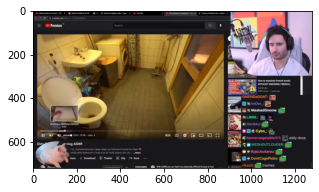

In [7]:
fpath=FRAMES_DIR+'03/0001.png'

image = cv2.imread(fpath)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(image_rgb)

results = face_mesh.process(image_rgb)
print(results.multi_face_landmarks)
if results.multi_face_landmarks:
    height,width,_=image.shape
    for face_landmarks in results.multi_face_landmarks:
        x1 = y1 = 1
        x2 = y2 = 0
        for id, lm in enumerate(face_landmarks.landmark):
            cx, cy = lm.x, lm.y
            if cx<x1:
                x1=cx
            if cy<y1:
                y1=cy
            if cx>x2:
                x2=cx
            if cy>y2:
                y2=cy
        if x1<0:
            x1=0
        if y1<0:
            y1=0
        x1,x2=int(x1*width),int(x2*width)
        y1,y2=int(y1*height),int(y2*height)
        face_img=image_rgb[y1:y2,x1:x2,:]
        plt.imshow(face_img)


In [20]:
from retinaface.pre_trained_models import get_model
model = get_model("resnet50_2020-07-20", max_size=1024,device='cuda')
model.eval()

In [10]:
import numpy as np
import cv2
import math
from skimage import transform as trans
def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped

[{'bbox': [-2.28, 272.56, 116.68, 454.52], 'score': 1.0, 'landmarks': [[50.06, 343.4], [102.51, 353.4], [89.88, 384.51], [42.34, 405.88], [85.07, 414.57]]}, {'bbox': [437.1, 310.1, 544.06, 457.11], 'score': 1.0, 'landmarks': [[461.51, 361.98], [508.56, 363.21], [478.87, 390.63], [462.5, 412.04], [507.82, 413.11]]}]
area: 21476
area: 15729


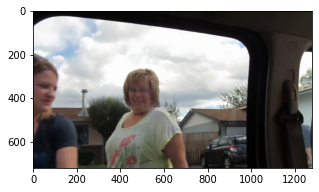

<Figure size 360x360 with 0 Axes>

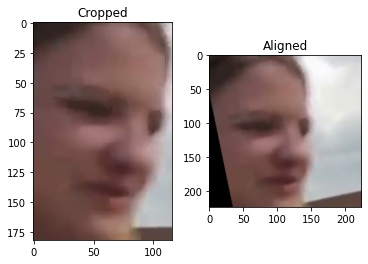

<Figure size 360x360 with 0 Axes>

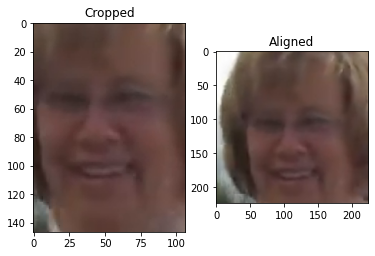

In [25]:
fpath=FRAMES_DIR+'53/0040.png'
image = cv2.imread(fpath)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(image_rgb)


annotations = model.predict_jsons(image_rgb)
print(annotations)
if not annotations[0]["bbox"]:
    print('No faces')
else:
    for annotation in annotations:
        box = np.array(annotation['bbox']).astype(int)
        x1,y1,x2,y2=box[0:4]
        print('area:',(y2-y1)*(x2-x1))
        x1=max(x1,0)
        y1=max(y1,0)
        face_img=image_rgb[y1:y2,x1:x2,:]
        p=np.array(annotation['landmarks'])
        
        plt.figure(figsize=(5, 5))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('Cropped')
        ax1.imshow(face_img)
        
        face_img=preprocess(image_rgb,box,p)
        ax2.set_title('Aligned')
        ax2.imshow(face_img)


In [26]:
if not os.path.exists(FACES_DIR):
    os.mkdir(FACES_DIR)
for folder in tqdm(os.listdir(FRAMES_DIR)):
    folder_full_path=os.path.join(FACES_DIR, folder)
    if not os.path.exists(folder_full_path):
        os.mkdir(folder_full_path)

        for image_file in os.listdir(os.path.join(FRAMES_DIR, folder)):
            filename = os.path.join(FRAMES_DIR, folder, image_file)
            image = cv2.imread(filename)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            annotations = model.predict_jsons(image_rgb)
            if len(annotations)==0 or not annotations[0]["bbox"]:
                pass #print('No faces')
            else:
                root,ext=os.path.splitext(image_file)
                faces_folder=os.path.join(folder_full_path, root) 
                if not os.path.exists(faces_folder):
                    os.mkdir(faces_folder)
                for i,annotation in enumerate(annotations):
                    outfile=os.path.join(faces_folder, str(i)+ext)
                    if not os.path.exists(outfile):
                        box = np.array(annotation['bbox']).astype(int)
                        x1,y1,x2,y2=box[0:4]    
                        x1=max(x1,0)
                        y1=max(y1,0)
                        face_img=image[y1:y2,x1:x2,:]
                        if np.prod(face_img.shape)==0:
                            print('Empty face ', x1,x2,y1,y2,folder,image_file)
                            continue
                        cv2.imwrite(outfile, face_img) 

100%|██████████| 56/56 [33:27<00:00, 35.85s/it] 


In [ ]:
if not os.path.exists(FACES_DIR):
    os.mkdir(FACES_DIR)
for folder in tqdm(os.listdir(FRAMES_DIR)):
    folder_full_path=os.path.join(FACES_DIR, folder)
    if not os.path.exists(folder_full_path):
        os.mkdir(folder_full_path)

        for image_file in os.listdir(os.path.join(FRAMES_DIR, folder)):
            filename = os.path.join(FRAMES_DIR, folder, image_file)
            image = cv2.imread(filename)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            results = face_mesh.process(image_rgb)
            if results.multi_face_landmarks:
                height,width,_=image.shape
                for face_landmarks in results.multi_face_landmarks:
                    x1 = y1 = 1
                    x2 = y2 = 0
                    for id, lm in enumerate(face_landmarks.landmark):
                        cx, cy = lm.x, lm.y
                        if cx<x1:
                            x1=cx
                        if cy<y1:
                            y1=cy
                        if cx>x2:
                            x2=cx
                        if cy>y2:
                            y2=cy
                    if x1<0:
                        x1=0
                    if y1<0:
                        y1=0
                    x1,x2=int(x1*width),int(x2*width)
                    y1,y2=int(y1*height),int(y2*height)
                    face_img=image_rgb[y1:y2,x1:x2,:]
                    if np.prod(face_img.shape)==0:
                        print('Empty face ', x1,x2,y1,y2,folder,image_file)
                        continue
                    cv2.imwrite(os.path.join(folder_full_path, image_file), face_img) 

In [27]:
for folder in sorted(os.listdir(FACES_DIR)):
    print(folder, len(os.listdir(os.path.join(FACES_DIR, folder))), len(os.listdir(os.path.join(FRAMES_DIR, folder))))

01 644 659
02 157 278
03 302 302
04 1094 1204
05 188 188
06 48 61
07 128 128
08 302 302
09 35 87
10 33 35
11 215 228
12 431 444
13 69 69
14 5315 5459
15 476 786
16 265 265
17 61 67
18 175 282
19 99 255
20 205 205
21 312 377
22 56 68
23 66 66
24 421 626
25 266 266
26 1989 2438
27 56 56
28 234 329
29 91 91
30 70 72
31 770 773
32 412 412
33 192 192
34 56 56
35 196 196
36 577 577
37 144 154
38 669 703
39 384 495
40 432 768
41 203 319
42 434 563
43 63 75
44 378 386
45 61 61
46 352 352
47 38 180
48 102 104
49 592 597
50 234 273
51 482 482
52 75 76
53 334 442
54 344 478
55 1097 1465
56 217 266


# Extract features

In [6]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

print(f"Torch: {torch.__version__}")
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

Torch: 2.0.1+cu118
True


In [7]:
#num_classes=7
if True:
    #PATH='affectnet_vggface2_enet2_gmp_smooth.pt'
    PATH='enet_b2_8_best.pt'
    #PATH='enet_b2_7.pt'
    IMG_SIZE=260 #224 #
else:
    #PATH='affectnet_vggface2_enet0.pt'
    #PATH='affectnet_vggface2_enet0_new.pt'
    #PATH='enet_b0_7.pt'
    #PATH='enet_b0_8_best_afew.pt'
    PATH='enet_b0_8_best_vgaf.pt'
    #PATH='enet_b0_8_va_mtl.pt'
    #PATH='affectnet_vggface2_mobilevit_mtl_new.pt'
    
    IMG_SIZE=224
    
#IMG_SIZE=112

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
np_transforms = transforms.Compose(
    [
        transforms.ToPILImage(None),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)


In [7]:
if False:
    PATH='affectnet_vggface2_mbf_va.pt'
    
    IMG_SIZE=112
    
    test_transforms = transforms.Compose(
    [
        transforms.Resize((112,112)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
    ]
    )
    
    import sys
    sys.path.append("/home/avsavchenko/src/distr/insightface/recognition/arcface_torch/backbones/")
    import mobilefacenet

In [8]:
print(PATH)
feature_extractor_model = torch.load('/home/avsavchenko/src/face-emotion-recognition/models/affectnet_emotions/'+PATH)

enet_b2_8_best.pt


In [35]:
if True:
    IMG_SIZE=112
    
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])  
    
    import sys
    DDAMNFN_PATH='/home/avsavchenko/src/distr/DDAMFN'
    sys.path.append(DDAMNFN_PATH)
    from networks.DDAM import DDAMNet

    if True:
        feature_extractor_model = DDAMNet(num_class=8, num_head=2)
        model_name='affectnet8_epoch4_acc0.6462'
    else:
        feature_extractor_model = DDAMNet(num_class=10, num_head=2)
        model_name='affectnet8_epoch9_acc0.642_mtl_2'
    feature_extractor_model.load_state_dict(torch.load(DDAMNFN_PATH+'/checkpoints/'+model_name+'.pth')['model_state_dict'])
    feature_extractor_model.bn=torch.nn.Identity()
    

In [36]:
feature_extractor_model

DDAMNet(
  (features): Sequential(
    (0): Conv_block(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (1): Conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (2): Mix_Depth_Wise(
      (conv): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=128)
      )
      (conv_dw): MDConv(
        (mixed_depthwise_conv): ModuleList(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    

In [37]:
if False:
    classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.classifier.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier.bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.head.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.head.fc.bias.cpu().data.numpy()
else:
    classifier_weights=feature_extractor_model.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.fc.bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(8, 512) [[-0.02266632  0.03422606  0.04598025 ... -0.03784892 -0.02933266
  -0.02419638]
 [-0.06048942 -0.01143544  0.04876871 ... -0.00673319 -0.03489853
  -0.04350665]
 [ 0.00924769  0.01705422 -0.02023846 ... -0.04731875 -0.04449094
   0.01527624]
 ...
 [ 0.02578277  0.02344748  0.02957167 ...  0.03510113  0.03270051
  -0.02460761]
 [ 0.02018657 -0.03497695  0.01600289 ...  0.04777396  0.01695777
  -0.00137146]
 [ 0.01643609  0.00521718 -0.01940052 ...  0.0298525  -0.028677
   0.04591733]]
(8,) [ 0.0492584  -0.05201729 -0.02789966 -0.06214872 -0.05696991  0.05707647
 -0.00724991 -0.0286497 ]


In [38]:
if False:
    feature_extractor_model.classifier=torch.nn.Identity()
elif False:
    feature_extractor_model.head.fc=torch.nn.Identity()
else:
    feature_extractor_model.fc=torch.nn.Identity()
feature_extractor_model=feature_extractor_model.to(device)
feature_extractor_model.eval()

DDAMNet(
  (features): Sequential(
    (0): Conv_block(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (1): Conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (2): Mix_Depth_Wise(
      (conv): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=128)
      )
      (conv_dw): MDConv(
        (mixed_depthwise_conv): ModuleList(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    

In [12]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    return x

In [39]:
print(test_transforms)
data_dir=FACES_DIR
print(data_dir)

videoname2featuresAll={}
for videoname in tqdm(os.listdir(data_dir)):
    frames_dir=os.path.join(data_dir,videoname)
    X_global_features,X_global_scores,img_names=[],[],[]
    for filename in sorted(os.listdir(frames_dir)):
        faces_dir=os.path.join(frames_dir,filename)
        imgs=[]
        global_features=[]
        for img_name in sorted(os.listdir(faces_dir)):
            img = Image.open(os.path.join(faces_dir,img_name))
            img_tensor = test_transforms(img)
            if img.size:
                imgs.append(img_tensor)


        if len(imgs)>0:        
            if False:
                features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
            else: #DDAMNet
                features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
            features=features.data.cpu().numpy()

            scores=get_probab(features)
            #print(features.shape,scores.shape)

            #print(videoname,filename,features.shape)
            X_global_features.append(features)
            X_global_scores.append(scores)
            img_names.append(videoname+'/'+filename+'/'+img_name)

    #print(videoname,len(X_global_features))
    videoname2featuresAll[videoname]=(X_global_features,X_global_scores,img_names)

Compose(
    Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/CE/faces/


  0%|          | 0/56 [00:00<?, ?it/s]

## Pretrained on AffWild 

In [9]:
if False:
    MODEL2FEATURES='cexpr_enet_b0_8_best_vgaf.pickle'
    MLP_MODEL='../abaw5/expr_enet0_vgaf.h5'
else:
    MODEL2FEATURES='cexpr_enet_b0_8_va_mtl.pickle'
    MLP_MODEL='../abaw4/expr_enet0_mtl_va.h5'

In [7]:
print(MODEL2FEATURES)
with open(MODEL2FEATURES, 'rb') as handle:
    videoname2featuresAll=pickle.load(handle)
print(len(videoname2featuresAll))

cexpr_enet_b0_8_va_mtl.pickle
56


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
#from tensorflow.keras.applications import efficientnet as enet
import efficientnet.tfkeras as enet
#from tensorflow.keras.utils.generic_utils import CustomObjectScope
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K 

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2.12.0


In [15]:
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(128, input_shape=(1280,),activation='relu')) #256
    mlpModel.add(Dense(8,activation='softmax'))
else:
    mlpModel.add(Dense(8, input_shape=(1280,),activation='softmax'))
mlpModel.load_weights(MLP_MODEL)

In [12]:
AFFECTNET2AFFWILD=np.array([5,0,2,3,4,6,7,1])
AFFWILD2AFFECTNET={affwild:affectnet for affectnet,affwild in enumerate(AFFECTNET2AFFWILD)}
AFFWILD2AFFECTNET=np.array([AFFWILD2AFFECTNET[i] for i in range(len(AFFECTNET2AFFWILD))])
print(AFFWILD2AFFECTNET)

[1 7 2 3 4 0 5 6]


In [13]:
idx_to_class_2={0: 'Neutral', 1:'Angry', 2:'Disgust', 3:'Fear', 4:'Happy', 5:'Sad', 6:'Surprised', 7:'Other'} #ABAW
idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprised'} #AffectNet
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}
for idx,cls in idx_to_class_2.items():
    print(idx,cls,class_to_idx[cls] if cls in class_to_idx else 'None',AFFWILD2AFFECTNET[idx])
    

0 Neutral 5 1
1 Angry 0 7
2 Disgust 2 2
3 Fear 3 3
4 Happy 4 4
5 Sad 6 0
6 Surprised 7 5
7 Other None 6


In [16]:
for videoname in tqdm(videoname2featuresAll):
    X_global_features,_,img_names=videoname2featuresAll[videoname]
    X_global_scores=[]
    for frame_number in range(len(img_names)):
        features=X_global_features[frame_number]
        scores=mlpModel.predict(features,verbose=0)
        new_scores=scores[:,AFFWILD2AFFECTNET]
        X_global_scores.append(new_scores)
        #print(features.shape)
    videoname2featuresAll[videoname]=(X_global_features,X_global_scores,img_names)

100%|██████████| 56/56 [16:35<00:00, 17.77s/it]


### Save/load features 

In [6]:
import pickle
num_classes=8
if False:
    #model_name='enet_b2_8_best'
    #model_name='enet_b0_8_best_vgaf'
    #model_name='enet_b0_8_vgaf_abaw'
    #model_name='cexpr_enet_b0_8_mtl_abaw'
    model_name='ddamfnet_8'
    has_va=False
else:
    #model_name='enet_b0_8_va_mtl'
    #model_name='mobilevit_mtl'
    #model_name='mbf_va'
    model_name='ddamfnet_mtl'
    has_va=True

MODEL2FEATURES='cexpr_'+model_name+'.pickle' 

print(MODEL2FEATURES)

cexpr_ddamfnet_mtl.pickle


In [42]:
if False:
    with open(MODEL2FEATURES, 'wb') as handle:
        pickle.dump(videoname2featuresAll, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
filename=MODEL2FEATURES
with open(filename, 'rb') as handle:
    videoname2featuresAll=pickle.load(handle)
print(len(videoname2featuresAll))

56


# Audios

In [8]:
import wave, struct
from fnmatch import fnmatch
for filename in tqdm(os.listdir(VIDEO_DIR)):
    #print(filename)
    video_path=os.path.join(VIDEO_DIR,filename)
    fn=os.path.splitext(filename)[0]
    waveFile = os.path.join(AUDIO_DIR, fn+'.wav')
    command = "ffmpeg -i "+video_path+" -ac 1 -ar 16000 -vn "+waveFile
    #print(command)
    os.system(command=command)

100%|██████████| 56/56 [00:07<00:00,  7.30it/s]


In [7]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
import torch
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [10]:
videoname2audiofeatures={}
for filename in sorted(os.listdir(AUDIO_DIR)):
    videoname,_=os.path.splitext(filename)
    array, fs = torchaudio.load(os.path.join(AUDIO_DIR,filename))
    inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inp)
    videoname2audiofeatures[videoname]=outputs.last_hidden_state.numpy()[0]
    print(videoname,videoname2audiofeatures[videoname].shape)

01 (1098, 768)
02 (556, 768)
03 (503, 768)
04 (2040, 768)
05 (314, 768)
06 (122, 768)
07 (255, 768)
08 (604, 768)
09 (174, 768)
10 (71, 768)
11 (380, 768)
12 (740, 768)
13 (138, 768)
14 (10917, 768)
15 (1311, 768)
16 (442, 768)
17 (134, 768)
18 (470, 768)
19 (425, 768)
20 (410, 768)
21 (753, 768)
22 (136, 768)
23 (132, 768)
24 (1044, 768)
25 (443, 768)
26 (4063, 768)
27 (93, 768)
28 (549, 768)
29 (152, 768)
30 (143, 768)
31 (1546, 768)
32 (824, 768)
33 (320, 768)
34 (93, 768)
35 (327, 768)
36 (1153, 768)
37 (256, 768)
38 (1173, 768)
39 (990, 768)
40 (1281, 768)
41 (532, 768)
42 (939, 768)
43 (125, 768)
44 (644, 768)
45 (124, 768)
46 (703, 768)
47 (300, 768)
48 (207, 768)
49 (994, 768)
50 (545, 768)
51 (804, 768)
52 (152, 768)
53 (737, 768)
54 (797, 768)
55 (2444, 768)
56 (444, 768)


In [8]:
MODEL2AUDIOFEATURES='ce_wav2vec2.pickle'

if False:
    with open(MODEL2AUDIOFEATURES, 'wb') as handle:
        pickle.dump(videoname2audiofeatures, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2AUDIOFEATURES, 'rb') as handle:
        videoname2audiofeatures=pickle.load(handle)
print(len(videoname2audiofeatures),videoname2audiofeatures['01'].shape)

56 (1098, 768)


# Data expoloration

In [8]:
def scores2probabs(x):
    e_x = np.exp(x - np.max(x))#[np.newaxis])
    e_x = e_x / e_x.sum(axis=1)[:,None]
    return e_x

Information from original paper (https://openaccess.thecvf.com/content/CVPR2023/papers/Kollias_Multi-Label_Compound_Expression_Recognition_C-EXPR_Database__Network_CVPR_2023_paper.pdf)

Fearfully Surprised (14445 frames): V < 0, A > 0
Happily Surprised (24915 frames): V > 0, A > 0
Sadly Surprised (10780 frames): V < 0, A > 0
Disgustedly Surprised (10637 frames): V < 0, A > 0
Angrily Surprised (10535 frames): V < 0, A > 0
Sadly Fearful (10112 frames): V < 0, A > 0
Sadly Angry (8878 frames): V < 0, A > 0

In [9]:
freqs=np.array([14445, 24915, 10780, 10637, 10535, 10112, 8878])
probabs_orig=freqs/freqs.sum()
print(probabs_orig)

[0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454]


In [10]:
idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}
print('AffectNet:',idx_to_class,class_to_idx)

AffectNet: {0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'} {'Angry': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}


In [11]:
compound_classes=['Fear Surprise', 'Happy Surprise', 'Sad Surprise', 'Disgust Surprise', 'Angry Surprise', 'Sad Fear', 'Sad Angry']
compound_fer_indices=np.array([[class_to_idx[c] for c in cc.split(' ')] for cc in compound_classes])
print(compound_fer_indices)


[[3 7]
 [4 7]
 [6 7]
 [2 7]
 [0 7]
 [6 3]
 [6 0]]


In [20]:
total_frames=total_facial_frames=0
for videoname in sorted(videoname2featuresAll):
    frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
    total_frames+=frames_count
    facial_frames_count=len(videoname2featuresAll[videoname][0])
    total_facial_frames+=facial_frames_count
    print(videoname, facial_frames_count,frames_count,len(videoname2audiofeatures[videoname]))

print(total_facial_frames,total_frames)

01 644 659 1098
02 157 278 556
03 302 302 503
04 1094 1204 2040
05 188 188 314
06 48 61 122
07 128 128 255
08 302 302 604
09 35 87 174
10 33 35 71
11 215 228 380
12 431 444 740
13 69 69 138
14 5315 5459 10917
15 476 786 1311
16 265 265 442
17 61 67 134
18 175 282 470
19 99 255 425
20 205 205 410
21 312 377 753
22 56 68 136
23 66 66 132
24 421 626 1044
25 266 266 443
26 1989 2438 4063
27 56 56 93
28 234 329 549
29 91 91 152
30 70 72 143
31 770 773 1546
32 412 412 824
33 192 192 320
34 56 56 93
35 196 196 327
36 577 577 1153
37 144 154 256
38 669 703 1173
39 384 495 990
40 432 768 1281
41 203 319 532
42 434 563 939
43 63 75 125
44 378 386 644
45 61 61 124
46 352 352 703
47 38 180 300
48 102 104 207
49 592 597 994
50 234 273 545
51 482 482 804
52 75 76 152
53 334 442 737
54 344 478 797
55 1097 1465 2444
56 217 266 444
22641 26138


In [12]:
def get_videoname2compound_scores(videoname2featuresAll):
    videoname2compound_scores={}
    for videoname in sorted(videoname2featuresAll):
        X_global_features,X_global_scores,img_names=videoname2featuresAll[videoname]
        compound_scores={}
        for img_name,scores in zip(img_names,X_global_scores):
            frame_number=int(img_name.split('/')[1])

            if False:
                if has_va:
                    fer_scores=scores[:,:-2]
                    valences=scores[:,-2]
                    arousals=scores[:,-1]
                else:
                    fer_scores=scores
                    valences,arousals=None,None
            else:
                fer_scores=scores[:,:num_classes]
            fer_probabs=scores2probabs(fer_scores)
            compound_probabs=np.array([[[probabs[c] for c in cc] for cc in compound_fer_indices] for probabs in fer_probabs])
            max_faces_scores=compound_probabs.mean(axis=2).max(axis=0)
            compound_scores[frame_number]=max_faces_scores
        videoname2compound_scores[videoname]=compound_scores
    return videoname2compound_scores


In [17]:
videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)

In [13]:
def get_compound_scores(videoname,videoname2compound_scores):
    frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
    all_compound_scores=np.zeros((frames_count,len(compound_classes)))
    compound_scores=videoname2compound_scores[videoname]
    frame_numbers=sorted(compound_scores.keys())
    cur_ind=0
    for i in range(1,frames_count+1):
        if cur_ind>=len(frame_numbers):
            all_compound_scores[i-1]=compound_scores[cur_frame_number]
            continue
        cur_frame_number=frame_numbers[cur_ind]
        if i==cur_frame_number:
            all_compound_scores[i-1]=compound_scores[cur_frame_number]
            cur_ind+=1
        else:
            if cur_ind==0:
                all_compound_scores[i-1]=compound_scores[cur_frame_number]
            else:
                w=1-(i-frame_numbers[cur_ind-1])/(cur_frame_number-frame_numbers[cur_ind-1])
                avg_scores=w*compound_scores[frame_numbers[cur_ind-1]]+(1-w)*compound_scores[cur_frame_number]
                all_compound_scores[i-1]=avg_scores
    return all_compound_scores

## Check predictions 

In [24]:
delta=0
print('freqs from paper:',freqs/freqs.sum())

for model_name in ['ddamfnet_8','ddamfnet_mtl','enet_b2_8_best','enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl',
                   'mobilevit_mtl', 'mbf_va', 'enet_b0_8_vgaf_abaw','enet_b0_8_mtl_abaw']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
    compound_classes_counts=np.zeros(len(compound_classes))
    for videoname in sorted(videoname2compound_scores):
        compound_scores=get_compound_scores(videoname,videoname2compound_scores)
        for i in range(len(compound_scores)):
            i1=max(i-delta,0)
            max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
            compound_index=np.argmax(max_faces_scores)
            compound_classes_counts[compound_index]+=1
    compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
    print(model_name,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))


freqs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454]
ddamfnet_8 [0.06890351 0.3697299  0.08856837 0.07150509 0.03083633 0.19121585
 0.17924095] KL: 0.18467258532309613
ddamfnet_mtl [0.09182034 0.30411661 0.09660265 0.02115694 0.03523605 0.23372102
 0.21734639] KL: 0.268739424246824
enet_b2_8_best [0.14247456 0.15636238 0.02276379 0.29700054 0.00841686 0.30675645
 0.06622542] KL: 0.49680788628353023
enet_b0_8_best_vgaf [0.17706022 0.23942153 0.0988599  0.06098401 0.04131915 0.2137501
 0.1686051 ] KL: 0.11862078496424168
enet_b0_8_va_mtl [0.21665774 0.31961129 0.05566608 0.05933889 0.07031908 0.15494682
 0.1234601 ] KL: 0.08304831480955421
mobilevit_mtl [0.22262606 0.16202464 0.0681766  0.26616421 0.04801439 0.17361696
 0.05937715] KL: 0.1688888299250671
mbf_va [0.13019359 0.32860204 0.05872676 0.12273319 0.06645497 0.15268957
 0.14059989] KL: 0.060323047351097385
enet_b0_8_best_vgaf_abaw_expr [0.00830209 0.56415946 0.16650088 0.0246002  0.0394

In [21]:
def get_videoname2compound_scores_first(videoname2featuresAll):
    videoname2compound_scores={}
    for videoname in sorted(videoname2featuresAll):
        X_global_features,X_global_scores,img_names=videoname2featuresAll[videoname]
        compound_scores={}
        for img_name,scores in zip(img_names,X_global_scores):
            frame_number=int(img_name.split('/')[1])
            fer_scores=scores[:1,:num_classes] #first faces only
            fer_probabs=scores2probabs(fer_scores)
            compound_probabs=np.array([[[probabs[c] for c in cc] for cc in compound_fer_indices] for probabs in fer_probabs])
            max_faces_scores=compound_probabs.mean(axis=2).max(axis=0)
            compound_scores[frame_number]=max_faces_scores
        videoname2compound_scores[videoname]=compound_scores
    return videoname2compound_scores

for model_name in ['ddamfnet_8','ddamfnet_mtl','enet_b2_8_best','enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl',
                   'mobilevit_mtl', 'mbf_va', 'enet_b0_8_vgaf_abaw','enet_b0_8_mtl_abaw']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores_first(videoname2featuresAll)
    compound_classes_counts=np.zeros(len(compound_classes))
    for videoname in sorted(videoname2compound_scores):
        compound_scores=get_compound_scores(videoname,videoname2compound_scores)
        for i in range(len(compound_scores)):
            i1=max(i-delta,0)
            max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
            compound_index=np.argmax(max_faces_scores)
            compound_classes_counts[compound_index]+=1
    compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
    print(model_name,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))


ddamfnet_8 [0.06190221 0.35813758 0.09270028 0.07322672 0.03186931 0.19592165
 0.18624225] KL: 0.19202263576898448
ddamfnet_mtl [0.08753539 0.29064963 0.09664091 0.02192211 0.03615426 0.23509832
 0.23199939] KL: 0.2745751637027279
enet_b2_8_best [0.1284337  0.16470273 0.02391155 0.30277757 0.01189839 0.29508761
 0.07318846] KL: 0.4450538282920463
enet_b0_8_best_vgaf [0.16562094 0.22040707 0.10873058 0.06515418 0.04189303 0.21482133
 0.18337287] KL: 0.12255947279994284
enet_b0_8_va_mtl [0.2051802  0.29195042 0.06534547 0.06580458 0.07693779 0.15647716
 0.13830438] KL: 0.06265229506170765
mobilevit_mtl [0.19064198 0.20422374 0.0652307  0.25939246 0.04893259 0.17216313
 0.05941541] KL: 0.13681192688844962
mbf_va [0.11971077 0.30970235 0.06867396 0.12093504 0.07299717 0.16145076
 0.14652996] KL: 0.05189005225243018
enet_b0_8_best_vgaf_abaw_expr [0.0099472  0.55845895 0.1503558  0.03760808 0.04143393 0.12212105
 0.08007499] KL: 0.4879576376314462
enet_b0_8_va_mtl_abaw_mtl_expr [0.08558421 0

In [28]:
print('probabs from paper:',probabs_orig,'\n')

for model_name in ['ddamfnet_8','ddamfnet_mtl','enet_b2_8_best','enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl',
                   'mobilevit_mtl', 'mbf_va', 'enet_b0_8_vgaf_abaw','enet_b0_8_mtl_abaw']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
    for delta in [0,1,3,5,10]:
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            for i in range(len(compound_scores)):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
        compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
        print(model_name,delta, compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


probabs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454] 

ddamfnet_8 0 [0.06890351 0.3697299  0.08856837 0.07150509 0.03083633 0.19121585
 0.17924095] KL: 0.18467258532309613
ddamfnet_8 1 [0.06645497 0.37302012 0.0891805  0.06832964 0.03106588 0.19094804
 0.18100084] KL: 0.1908756689967354
ddamfnet_8 3 [0.0636621  0.3747035  0.09312113 0.06741143 0.02980335 0.18972377
 0.18157472] KL: 0.1981826754536086
ddamfnet_8 5 [0.06232305 0.37565996 0.0952636  0.06546025 0.02899992 0.19113934
 0.18115388] KL: 0.2042080248615054
ddamfnet_8 10 [0.05876502 0.37872064 0.09901293 0.06033361 0.02945903 0.19259316
 0.18111562] KL: 0.2137106039005009

ddamfnet_mtl 0 [0.09182034 0.30411661 0.09660265 0.02115694 0.03523605 0.23372102
 0.21734639] KL: 0.268739424246824
ddamfnet_mtl 1 [0.08807101 0.30514959 0.0982095  0.01981789 0.03336139 0.23792945
 0.21746117] KL: 0.2845329096315339
ddamfnet_mtl 3 [0.08244701 0.30893718 0.10084934 0.01779019 0.0316015  0.2411049


In [32]:
def get_videoname2compound_scores_first(videoname2featuresAll):
    videoname2compound_scores={}
    for videoname in sorted(videoname2featuresAll):
        X_global_features,X_global_scores,img_names=videoname2featuresAll[videoname]
        compound_scores={}
        for img_name,scores in zip(img_names,X_global_scores):
            frame_number=int(img_name.split('/')[1])
            fer_scores=scores[:1,:num_classes] #first faces only
            fer_probabs=scores2probabs(fer_scores)
            compound_probabs=np.array([[[probabs[c] for c in cc] for cc in compound_fer_indices] for probabs in fer_probabs])
            max_faces_scores=compound_probabs.mean(axis=2).max(axis=0)
            compound_scores[frame_number]=max_faces_scores
        videoname2compound_scores[videoname]=compound_scores
    return videoname2compound_scores

probabs_orig=freqs/freqs.sum()
print('probabs from paper:',probabs_orig,'\n')

for model_name in ['ddamfnet_8','ddamfnet_mtl','enet_b2_8_best','enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl',
                   'mobilevit_mtl', 'mbf_va', 'enet_b0_8_vgaf_abaw','enet_b0_8_mtl_abaw']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores_first(videoname2featuresAll)
    for delta in [0,1,3,5,10]:
        compound_classes_counts=np.zeros(len(compound_classes))
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            for i in range(len(compound_scores)):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
        compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
        print(model_name,delta, compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


probabs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454] 

ddamfnet_8 0 [0.06190221 0.35813758 0.09270028 0.07322672 0.03186931 0.19592165
 0.18624225] KL: 0.19202263576898448
ddamfnet_8 1 [0.05949193 0.36173387 0.09312113 0.06894177 0.03263448 0.19664856
 0.18742827] KL: 0.19837412325688455
ddamfnet_8 3 [0.05646951 0.36525365 0.09744433 0.06576632 0.03121891 0.19561558
 0.18823169] KL: 0.20952275049863103
ddamfnet_8 5 [0.05589563 0.36678399 0.09897467 0.06327952 0.03030071 0.19691637
 0.18784911] KL: 0.21562402576661552
ddamfnet_8 10 [0.05252889 0.37137501 0.1018058  0.05742597 0.02980335 0.19921188
 0.18784911] KL: 0.23082917641488174

ddamfnet_mtl 0 [0.08753539 0.29064963 0.09664091 0.02192211 0.03615426 0.23509832
 0.23199939] KL: 0.2745751637027279
ddamfnet_mtl 1 [0.08432168 0.29225648 0.09878338 0.02039177 0.03527431 0.23796771
 0.23100467] KL: 0.28688230374412355
ddamfnet_mtl 3 [0.07927156 0.29650318 0.10153799 0.01809626 0.03286403 0.24

# Clustering

In [17]:
from sklearn.cluster import KMeans
def get_video_name(id):
    name = ""
    if id>=0 and id<10:
        name = "0" + str(id)
    else:
        name = str(id)
    return name

num_clusters=len(freqs)
print(num_clusters)

7


In [38]:
def get_cluster_compound_labels(videoname2featuresAll,compound_labels):
    all_compound_labels=None
    ind=0
    for videoname in sorted(videoname2featuresAll):
        frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
        _,_,img_names=videoname2featuresAll[videoname]
        cur_compound_labels,frame_numbers=[],[]
        for img_name in img_names:
            frame_number=int(img_name.split('/')[1])
            frame_numbers.append(frame_number)
            cur_compound_labels.append(compound_labels[ind])
            ind+=1

        cur_ind=0
        video_compound_labels=np.zeros(frames_count)
        for i in range(1,frames_count+1):
            if cur_ind>=len(frame_numbers):
                video_compound_labels[i-1]=cur_compound_labels[-1]
                continue
            cur_frame_number=frame_numbers[cur_ind]
            if i==cur_frame_number:
                video_compound_labels[i-1]=cur_compound_labels[cur_ind]
                cur_ind+=1
            else:
                if cur_ind==0:
                    video_compound_labels[i-1]=cur_compound_labels[0]
                else:
                    w=1-(i-frame_numbers[cur_ind-1])/(frame_numbers[cur_ind]-frame_numbers[cur_ind-1])
                    ci=cur_ind-1 if w>0.5 else cur_ind
                    video_compound_labels[i-1]=cur_compound_labels[ci]
        video_compound_labels=np.array(video_compound_labels)
        if all_compound_labels is None:
            all_compound_labels=video_compound_labels
        else:
            all_compound_labels=np.concatenate((all_compound_labels,video_compound_labels))
    return all_compound_labels

In [43]:
def cluster_analysis(videoname2featuresAll,X,indices):
    cls=KMeans(n_clusters=num_clusters)
    labels=cls.fit_predict(X)

    cluster_compound_closeness=np.zeros((num_clusters,num_clusters))
    for c in range(num_clusters):
        for (videoname,ind) in indices[labels==c]:
            if ind==-1:
                continue
            X_global_features,X_global_scores,img_names=videoname2featuresAll[get_video_name(videoname)]
            scores=X_global_scores[ind]
            fer_scores=scores[:1,:num_classes] #first faces only
            fer_probabs=scores2probabs(fer_scores)
            compound_probabs=np.array([[[probabs[c] for c in cc] for cc in compound_fer_indices] for probabs in fer_probabs])
            max_faces_scores=compound_probabs.mean(axis=2).max(axis=0)
            compound_index=np.argmax(max_faces_scores)
            cluster_compound_closeness[c,compound_index]+=1
        cluster_compound_closeness[c,:]/=cluster_compound_closeness[c,:].sum()
        #print(c,cluster_compound_closeness[c,:])

    cluster_indices=[i for i in range(num_clusters)]
    cur_indices=[i for i in range(num_clusters)]
    compound_clusters=[-1]*num_clusters
    for _ in range(num_clusters):
        #print(cluster_compound_closeness)
        m=cluster_compound_closeness[cluster_indices][:,cur_indices].max()
        found=False
        for c in cluster_indices:
            for j in cur_indices:
                if m==cluster_compound_closeness[c][j]:
                    found=True
                    break
            if found:
                break
        if not found:
            print('Error',m,cluster_compound_closeness[cur_indices][:,cur_indices])
        compound_clusters[c]=j
        cluster_indices.remove(c)
        cur_indices.remove(j)
        #print(c,j,cluster_indices,cur_indices,m)
    #print(compound_clusters)
    compound_labels=np.array([compound_clusters[c] for c in labels])
    return compound_labels

def get_video_features(videoname2featuresAll,use_scores=True):
    X,indices=[],[]
    for videoname in sorted(videoname2featuresAll):
        X_global_features,X_global_scores,img_names=videoname2featuresAll[videoname]
        i=0
        for img_name,features,scores in zip(img_names,X_global_features,X_global_scores):
            if use_scores:
                x=scores[0,:]
            else:
                x=features[0,:]
            X.append(x)
            indices.append((int(videoname),i))
            i+=1

    X=np.array(X)
    indices=np.array(indices)
    print(X.shape,indices.shape)
    return X,indices


def get_audio_features(videoname2featuresAll):
    X,indices=[],[]
    for videoname in sorted(videoname2featuresAll):
        X_global_features,X_global_scores,img_names=videoname2featuresAll[videoname]
        audio_features=videoname2audiofeatures[videoname]
        frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
        audio_scale=len(audio_features)/frames_count
        
        frame2ind={int(img_name.split('/')[1])-1:i for i,img_name in enumerate(img_names)}
        for frame_number in range(frames_count):
            ind=int(frame_number*audio_scale)
            x=audio_features[ind]
            X.append(x)
            if frame_number in frame2ind:
                i=frame2ind[frame_number]
            else:
                i=-1
            indices.append((int(videoname),i))

    X=np.array(X)
    indices=np.array(indices)
    print(X.shape,indices.shape)
    return X,indices

def get_audio_features1(videoname2featuresAll):
    X,indices=[],[]
    for videoname in sorted(videoname2featuresAll):
        X_global_features,X_global_scores,img_names=videoname2featuresAll[videoname]
        audio_features=videoname2audiofeatures[videoname]
        frames_count=len(os.listdir(os.path.join(FRAMES_DIR, videoname)))
        audio_scale=len(audio_features)/frames_count
        for i,img_name in enumerate(img_names):
            frame_number=int(img_name.split('/')[1])-1
            ind=int(frame_number*audio_scale)
            x=audio_features[ind]
            X.append(x)
            indices.append((int(videoname),i))

    X=np.array(X)
    indices=np.array(indices)
    print(X.shape,indices.shape)
    return X,indices

In [36]:
X,indices=get_video_features(videoname2featuresAll,use_scores=True)
compound_labels=cluster_analysis(videoname2featuresAll,X,indices)
unique_labels,histo=np.unique(compound_labels, return_counts=True)
histo=histo.astype('float64')/histo.sum()
#print(unique_labels,histo, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / histo)))
print(compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / histo)))

(22641, 10) (22641, 2)
[0.09306126 0.16916214 0.14173402 0.03453911 0.34848284 0.12640784
 0.08661278] KL: 0.2510702944675047


In [44]:
X,indices=get_audio_features(videoname2featuresAll)

compound_labels=cluster_analysis(videoname2featuresAll,X,indices)
unique_labels,compound_classes_probabs=np.unique(compound_labels, return_counts=True)
compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()

print(compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))

(26138, 768) (26138, 2)
[0.1846354  0.1390313  0.10467519 0.05601041 0.12441656 0.26260617
 0.12862499] KL: 0.14003923550260836


In [77]:
for model_name in ['ddamfnet_8','ddamfnet_mtl','enet_b2_8_best','enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl',
                   'mobilevit_mtl', 'mbf_va', 'enet_b0_8_vgaf_abaw','enet_b0_8_mtl_abaw']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)
    X,indices=get_video_features(videoname2featuresAll,use_scores=True)
    compound_labels=cluster_analysis(videoname2featuresAll,X,indices)
    if False:
        unique_labels,compound_classes_probabs=np.unique(compound_labels, return_counts=True)
        compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
        #print(unique_labels,histo, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / histo)))
        print(model_name,'scores',compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    
    all_compound_labels=get_cluster_compound_labels(videoname2featuresAll,compound_labels)
    unique_labels,compound_classes_probabs=np.unique(all_compound_labels, return_counts=True)
    compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
    print(model_name,'scores',compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))

    
    X,indices=get_video_features(videoname2featuresAll,use_scores=False)
    compound_labels=cluster_analysis(videoname2featuresAll,X,indices)
    if False:
        unique_labels,compound_classes_probabs=np.unique(compound_labels, return_counts=True)
        compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
        #print(unique_labels,histo, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / histo)))
        print(model_name,'scores',compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    
    all_compound_labels=get_cluster_compound_labels(videoname2featuresAll,compound_labels)
    unique_labels,compound_classes_probabs=np.unique(all_compound_labels, return_counts=True)
    compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
    print(compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    
    if True:
        X,indices=get_audio_features(videoname2featuresAll)

        compound_labels=cluster_analysis(videoname2featuresAll,X,indices)
        unique_labels,compound_classes_probabs=np.unique(compound_labels, return_counts=True)
        compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()

        print('audios',compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()

(22641, 8) (22641, 2)
ddamfnet_8 scores [0.08830056 0.16527661 0.24121968 0.05746423 0.220101   0.09579922
 0.1318387 ] KL: 0.15158674307119513
(22641, 512) (22641, 2)
[0.12250363 0.14389012 0.4162522  0.07058688 0.06637845 0.07728212
 0.10310659] KL: 0.23615666029886284
(26138, 768) (26138, 2)
audios [0.18471191 0.10463693 0.13945214 0.26210881 0.05597215 0.12411049
 0.12900758] KL: 0.17918441136749155

(22641, 10) (22641, 2)
ddamfnet_mtl scores [0.15039406 0.09985462 0.3203382  0.09610529 0.08707629 0.10119366
 0.14503788] KL: 0.20366044144875947
(22641, 512) (22641, 2)
[0.059798   0.11148519 0.26142015 0.09262377 0.21248757 0.09124646
 0.17093886] KL: 0.2407602501708826
(26138, 768) (26138, 2)
audios [0.1844441  0.13918433 0.05597215 0.12896932 0.10448389 0.12430178
 0.26264443] KL: 0.15032593625193086

(22641, 8) (22641, 2)
enet_b2_8_best scores [0.08845359 0.19990053 0.15854312 0.04281123 0.3128778  0.1006963
 0.09671742] KL: 0.16744661128838698
(22641, 1408) (22641, 2)
[0.1142398

## Models agreements  

In [70]:
probabs_orig=freqs/freqs.sum()
print('probabs from paper:',probabs_orig,'\n')

model2compound_labels={}
for model_name in ['ddamfnet_8','ddamfnet_mtl','enet_b2_8_best','enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl',
                   'mobilevit_mtl', 'mbf_va', 'enet_b0_8_vgaf_abaw','enet_b0_8_mtl_abaw']: 

    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)
    videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
    compound_labels=[]
    for videoname in sorted(videoname2compound_scores):
        compound_scores=get_compound_scores(videoname,videoname2compound_scores)
        for i in range(len(compound_scores)):
            compound_index=np.argmax(compound_scores[i])
            compound_labels.append(compound_index)

    compound_labels=np.array(compound_labels)
    model2compound_labels[model_name]=compound_labels
    
    unique_labels,compound_classes_probabs=np.unique(compound_labels, return_counts=True)
    compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
    print(model_name,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    print()


probabs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454] 

ddamfnet_8 [0.06890351 0.3697299  0.08856837 0.07150509 0.03083633 0.19121585
 0.17924095] KL: 0.18467258532309613

ddamfnet_mtl [0.09182034 0.30411661 0.09660265 0.02115694 0.03523605 0.23372102
 0.21734639] KL: 0.268739424246824

enet_b2_8_best [0.14247456 0.15636238 0.02276379 0.29700054 0.00841686 0.30675645
 0.06622542] KL: 0.49680788628353023

enet_b0_8_best_vgaf [0.17706022 0.23942153 0.0988599  0.06098401 0.04131915 0.2137501
 0.1686051 ] KL: 0.11862078496424168

enet_b0_8_va_mtl [0.21665774 0.31961129 0.05566608 0.05933889 0.07031908 0.15494682
 0.1234601 ] KL: 0.08304831480955421

mobilevit_mtl [0.22262606 0.16202464 0.0681766  0.26616421 0.04801439 0.17361696
 0.05937715] KL: 0.1688888299250671

mbf_va [0.13019359 0.32860204 0.05872676 0.12273319 0.06645497 0.15268957
 0.14059989] KL: 0.060323047351097385

enet_b0_8_vgaf_abaw [0.00830209 0.56415946 0.16650088 0.0246002  0.039

In [74]:
with open('cexpr_mbf_va.pickle' , 'rb') as handle:
    videoname2featuresAll=pickle.load(handle)
    
X,indices=get_audio_features(videoname2featuresAll)

audio_compound_labels=cluster_analysis(videoname2featuresAll,X,indices)
unique_labels,compound_classes_probabs=np.unique(audio_compound_labels, return_counts=True)
compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
print('audios',compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
model2compound_labels['wav2vec2 clustering']=audio_compound_labels

(26138, 768) (26138, 2)
audios [0.18478843 0.13933736 0.10459867 0.05601041 0.12453133 0.26207055
 0.12866325] KL: 0.13947909575557957


In [75]:
from sklearn.metrics import cohen_kappa_score
kappas=np.zeros((len(model2compound_labels),len(model2compound_labels)))

for i1,model_name1 in enumerate(model2compound_labels):
    compound_labels1=model2compound_labels[model_name1]
    for i2,model_name2 in enumerate(model2compound_labels):
        compound_labels2=model2compound_labels[model_name2]
        kappas[i1,i2]=cohen_kappa_score(compound_labels1,compound_labels2)
        print(model_name1,model_name2,kappas[i1,i2],(compound_labels1==compound_labels2).mean())
    print()

ddamfnet_8 ddamfnet_8 1.0 1.0
ddamfnet_8 ddamfnet_mtl 0.5455754019750855 0.6426275920116306
ddamfnet_8 enet_b2_8_best 0.3270448201277185 0.4358405386793175
ddamfnet_8 enet_b0_8_best_vgaf 0.4196313810361144 0.5276991353584819
ddamfnet_8 enet_b0_8_va_mtl 0.404468180123724 0.5213099701583901
ddamfnet_8 mobilevit_mtl 0.32090940186773254 0.41981023796770983
ddamfnet_8 mbf_va 0.4231861592984494 0.5390619022113398
ddamfnet_8 enet_b0_8_vgaf_abaw 0.1693091999686731 0.38832351365827533
ddamfnet_8 enet_b0_8_mtl_abaw 0.23329699237067048 0.4123880939628128
ddamfnet_8 wav2vec2 clustering 0.0073679136065145645 0.16076210880710076

ddamfnet_mtl ddamfnet_8 0.5455754019750855 0.6426275920116306
ddamfnet_mtl ddamfnet_mtl 1.0 1.0
ddamfnet_mtl enet_b2_8_best 0.3177780917550247 0.4238656362384268
ddamfnet_mtl enet_b0_8_best_vgaf 0.4405613777648164 0.545718876731196
ddamfnet_mtl enet_b0_8_va_mtl 0.4121657903328796 0.5234141862422527
ddamfnet_mtl mobilevit_mtl 0.2827962447330046 0.3811309204988905
ddamfnet_mt

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass display_labels=dict_keys(['ddamfnet_8', 'ddamfnet_mtl', 'enet_b2_8_best', 'enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl', 'mobilevit_mtl', 'mbf_va', 'enet_b0_8_vgaf_abaw', 'enet_b0_8_mtl_abaw', 'wav2vec2 clustering']) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


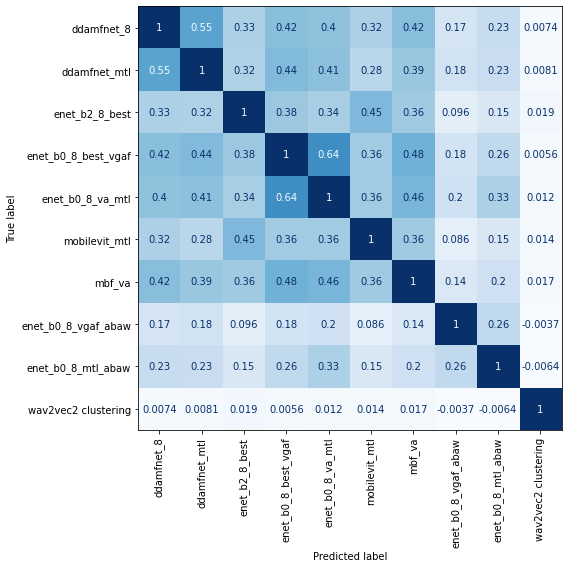

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay
disp=ConfusionMatrixDisplay(kappas,model2compound_labels.keys())
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(
        include_values=True,
        cmap=plt.cm.Blues,
        ax=ax,
        xticks_rotation="vertical",
        values_format=None,
        colorbar=False,
    )
plt.tight_layout()
plt.show()

In [62]:
for model_name in ['ddamfnet_8','ddamfnet_mtl','enet_b2_8_best','enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl',
                   'mobilevit_mtl', 'mbf_va', 'enet_b0_8_vgaf_abaw','enet_b0_8_mtl_abaw']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)
    X,indices=get_video_features(videoname2featuresAll,use_scores=True)
    compound_labels=cluster_analysis(videoname2featuresAll,X,indices)    
    all_compound_labels=get_cluster_compound_labels(videoname2featuresAll,compound_labels)
    unique_labels,compound_classes_probabs=np.unique(all_compound_labels, return_counts=True)
    compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
    print(model_name,'scores',compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))
    
    compound_labels1=model2compound_labels[model_name]
    print(cohen_kappa_score(compound_labels1,all_compound_labels),(compound_labels1==all_compound_labels).mean())
    

(22641, 8) (22641, 2)
ddamfnet_8 scores [0.08661719 0.16183335 0.23333843 0.05765552 0.23276456 0.09453669
 0.13325427] KL: 0.15795785952718672
0.2844788821289518 0.3844594077588186
(22641, 10) (22641, 2)
ddamfnet_mtl scores [0.15135052 0.10119366 0.31892264 0.09641136 0.08604331 0.10149973
 0.14457877] KL: 0.20049094117769664
0.3229196638770656 0.41479837784069173
(22641, 8) (22641, 2)
enet_b2_8_best scores [0.08849185 0.19974749 0.15858138 0.04273472 0.31299258 0.10077282
 0.09667916] KL: 0.16768170855571915
0.32904727214338414 0.39620475935419697
(22641, 8) (22641, 2)
enet_b0_8_best_vgaf scores [0.40064274 0.00726911 0.15161833 0.09224118 0.0717729  0.0968322
 0.17962354] KL: 0.8704118907517125
0.30505095396083115 0.40737623383579463
(22641, 10) (22641, 2)
enet_b0_8_va_mtl scores [0.12992578 0.10310659 0.3255031  0.07533094 0.09082562 0.10754457
 0.16776341] KL: 0.21895477254601686
0.2984038346096046 0.3878261534929987
(22641, 10) (22641, 2)
mobilevit_mtl scores [0.08853011 0.228441

# Save test results 

In [14]:
OUTPUT_DIR=DATA_DIR+'outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(OUTPUT_DIR)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/CE/outputs/


In [15]:
with open(DATA_DIR+'../test_set_examples/CVPR_6th_ABAW_CE_test_set_example.txt', 'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])


26146 ['image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry', '01/00001.jpg,0', '01/00002.jpg,6', '01/00003.jpg,3', '01/00004.jpg,5']


In [18]:
correct_filepaths=set()
for line in test_set_sample[1:]:
    correct_filepaths.add(line.split(',')[0])

filepaths=set()
for videoname in sorted(videoname2compound_scores):
    compound_scores=get_compound_scores(videoname,videoname2compound_scores)
    for i in range(len(compound_scores)):
        filepaths.add(videoname+'/'+get_names(i+1)+'.jpg')

print(correct_filepaths-filepaths,filepaths-correct_filepaths)

videos_with_new_frame,videos_with_extra_frame=[],[]
for filepath in (correct_filepaths-filepaths):
    videos_with_new_frame.append(filepath.split('/')[0])
for filepath in (filepaths-correct_filepaths):
    videos_with_extra_frame.append(filepath.split('/')[0])
    
print(videos_with_new_frame,videos_with_extra_frame)

{'51/00483.jpg', '05/00189.jpg', '16/00266.jpg', '24/00627.jpg', '43/00076.jpg', '40/00769.jpg', '56/00267.jpg', '33/00193.jpg', '44/00387.jpg', '28/00330.jpg', '29/00092.jpg'} {'09/00087.jpg', '10/00035.jpg', '45/00061.jpg', '22/00068.jpg'}
['51', '05', '16', '24', '43', '40', '56', '33', '44', '28', '29'] ['09', '10', '45', '22']


In [19]:
delta=0
print('freqs from paper:',freqs/freqs.sum())

for model_name in ['ddamfnet_mtl', 'enet_b0_8_best_vgaf', 'enet_b0_8_va_mtl','mbf_va', 'enet_b0_8_mtl_abaw']: 
    with open('cexpr_'+model_name+'.pickle' , 'rb') as handle:
        videoname2featuresAll=pickle.load(handle)

    videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
    compound_classes_counts=np.zeros(len(compound_classes))
    filepaths=set()
    with open(os.path.join(OUTPUT_DIR,model_name+'.txt'), 'w') as f:
        f.write('image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry\n')
        for videoname in sorted(videoname2compound_scores):
            compound_scores=get_compound_scores(videoname,videoname2compound_scores)
            max_i=len(compound_scores)
            if videoname in videos_with_extra_frame:
                max_i-=1
            for i in range(max_i):
                i1=max(i-delta,0)
                max_faces_scores=np.mean(compound_scores[i1:i+delta+1],axis=0)
                compound_index=np.argmax(max_faces_scores)
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+1)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')
            if videoname in videos_with_new_frame:
                compound_classes_counts[compound_index]+=1
                filepath=videoname+'/'+get_names(i+2)+'.jpg'
                filepaths.add(filepath)
                f.write(filepath +','+str(compound_index)+'\n')

    compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
    print(model_name,correct_filepaths-filepaths,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))


freqs from paper: [0.15996323 0.27590751 0.1193772  0.11779363 0.11666408 0.1119798
 0.09831454]
ddamfnet_mtl set() [0.09171926 0.30403519 0.09672978 0.02118952 0.03526487 0.23369669
 0.2173647 ] KL: 0.26855924042080587
enet_b0_8_best_vgaf set() [0.17701281 0.23931918 0.09887168 0.06104418 0.04134634 0.21373111
 0.1686747 ] KL: 0.11854384057644596
enet_b0_8_va_mtl set() [0.21667623 0.31952572 0.05568942 0.0593995  0.07030025 0.15490534
 0.12350354] KL: 0.08296487654779017
mbf_va set() [0.13008223 0.32859055 0.05871103 0.12285332 0.06647543 0.15268694
 0.1406005 ] KL: 0.06035189095157949
enet_b0_8_mtl_abaw set() [0.08192771 0.46188564 0.02727099 0.05125263 0.12231784 0.12690763
 0.12843756] KL: 0.19333999705208277


In [93]:
with open('cexpr_mbf_va.pickle' , 'rb') as handle:
    videoname2featuresAll=pickle.load(handle)
    
X,indices=get_audio_features(videoname2featuresAll)

audio_compound_labels=cluster_analysis(videoname2featuresAll,X,indices)
unique_labels,compound_classes_probabs=np.unique(audio_compound_labels, return_counts=True)
compound_classes_probabs=compound_classes_probabs.astype('float64')/compound_classes_probabs.sum()
print('audios',compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))

(26138, 768) (26138, 2)
audios [0.18471191 0.13945214 0.10456041 0.05601041 0.12426352 0.2623001
 0.12870151] KL: 0.139485730151627


In [97]:
videoname2compound_scores=get_videoname2compound_scores(videoname2featuresAll)
compound_classes_counts=np.zeros(len(compound_classes))
filepaths=set()
ind=0
with open(os.path.join(OUTPUT_DIR,'wav2vec2_mbf.txt'), 'w') as f:
    f.write('image_location,Fearfully_Surprised,Happily_Surprised,Sadly_Surprised,Disgustedly_Surprised,Angrily_Surprised,Sadly_Fearful,Sadly_Angry\n')
    for videoname in sorted(videoname2compound_scores):
        compound_scores=get_compound_scores(videoname,videoname2compound_scores)
        max_i=len(compound_scores)
        if videoname in videos_with_extra_frame:
            max_i-=1
        for i in range(max_i):
            compound_index=audio_compound_labels[ind]
            ind+=1
            compound_classes_counts[compound_index]+=1
            filepath=videoname+'/'+get_names(i+1)+'.jpg'
            filepaths.add(filepath)
            f.write(filepath +','+str(compound_index)+'\n')
        if videoname in videos_with_new_frame:
            compound_classes_counts[compound_index]+=1
            filepath=videoname+'/'+get_names(i+2)+'.jpg'
            filepaths.add(filepath)
            f.write(filepath +','+str(compound_index)+'\n')

compound_classes_probabs=compound_classes_counts/compound_classes_counts.sum()
print(model_name,correct_filepaths-filepaths,compound_classes_probabs, 'KL:',np.sum(probabs_orig * np.log(probabs_orig / compound_classes_probabs)))


enet_b0_8_mtl_abaw set() [0.18466246 0.1394913  0.10457066 0.05599541 0.1244215  0.26211513
 0.12874355] KL: 0.13936960444430324
